In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from osgeo import gdal
import glob
from affine import Affine
import pandas as pd
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import datetime
plt.style.use('seaborn-white')

import sys
sys.path.append('/Users/allen/Documents/Python/PlotGallary/')
from matplotlibconfig import basic

basic()

In [2]:
def retrieve_loc(sample_file_path):
    h5= h5py.File(sample_file_path,'r')
    grided_map= h5['Grid']
    lons= np.array(h5['Grid/lon'])
    lats= np.array(h5['Grid/lat'])
    data= np.array(h5['Grid/precipitationCal']).transpose()
    xmin, ymin, xmax, ymax = [lons.min(), lats.min(), lons.max(), lats.max()]
    xres, yres, _= data.shape
    ncol, nrow= int((xmax-xmin)//xres), int((ymax-ymin)//yres)
    lon_diff= lons[1]-lons[0]
    lat_diff= lats[1]-lats[0]
    
    return lons, lats, lon_diff, lat_diff

In [3]:
# declare some global variable including geo information
LON, LAT, LON_DIFF, LAT_DIFF= retrieve_loc('test_sample.HDF5')

In [4]:
def array2raster(newRasterfn, array, lon_diff, lons, lat_diff, lats):

    pixelWidth= lon_diff
    pixelHeight= lat_diff
    cols = array.shape[1]
    rows = array.shape[0]
    originX = lons[0]
    originY = lats[0]

    driver = gdal.GetDriverByName('GTiff')
    outdata = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    print(outdata)
    outdata.SetProjection("EPSG:4326")
    print(outdata)
    outdata.GetRasterBand(1).WriteArray(array)

In [5]:
def visual(src, *args, **kwargs):
    '''
    :args - [
            clabel - label shown in the colorbar
            ]
    '''
    cbLabel= args[0]
    listedCmap= args[1]
#     cmap_data= args[2]
    xres = LON_DIFF
    yres = LAT_DIFF
    xmin = LAT[0] + xres * 0.5
    xmax = LAT[-1] - xres * 0.5
    ymin = LON[0] + yres * 0.5
    ymax = LON[-1] - yres * 0.5
    x,y = np.meshgrid(LON, LAT)
#     src[src==np.inf]= np.nan
    
#     fig= plt.figure(figsize=(20,8))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(linewidth=1)
    m.drawparallels(np.arange(-90, 91, 30), labels=[True,False,False,True], dashes=[10,10], linewidth=.5, fontsize=15)
    m.drawmeridians(np.arange(-180, 180, 60), labels=[True,False,False,True], dashes=[10,10], linewidth=.5, fontsize=15)
    cmap= kwargs.get('cmap', None)
    if cmap is None: 
        if not listedCmap:
            cmap= plt.get_cmap('rainbow')
        elif listedCmap:
            cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    else:
        del kwargs['cmap']
    x,y = m(x,y)
    map = m.pcolormesh(x, y, src, cmap= cmap, **kwargs)
#     cb = m.colorbar(location="bottom", pad='10%', ticks=np.linspace(0, kwargs.get('vmax', np.nanmax(src)),
#                                                                                   len(cmap_data)+1).astype(int)) #this is for rain probability
    cb = m.colorbar(location="bottom", pad='10%')
    
#     cbar = fig.colorbar(cb, ticks=[0, 10, 20, 30, 40, 48])
#     cb.ax.set_xticklabels(['0:00', '5:00', '10:00', '15:00', '20:00', '23:59'])
    cb.set_label(cbLabel)
    
    return map


In [6]:
season= h5py.File('datasets/seasonalStats.h5')

In [7]:
season.keys()

<KeysViewHDF5 ['DJF', 'JJA', 'MAM', 'SON']>

In [21]:
array2raster('JJA_global.tif', np.flip(np.array(season['JJA'][9,:,:]), axis=0), LON_DIFF, LON, LAT_DIFF, LAT)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x12415de70> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x12415de70> >


### Total rainfall amount for final product

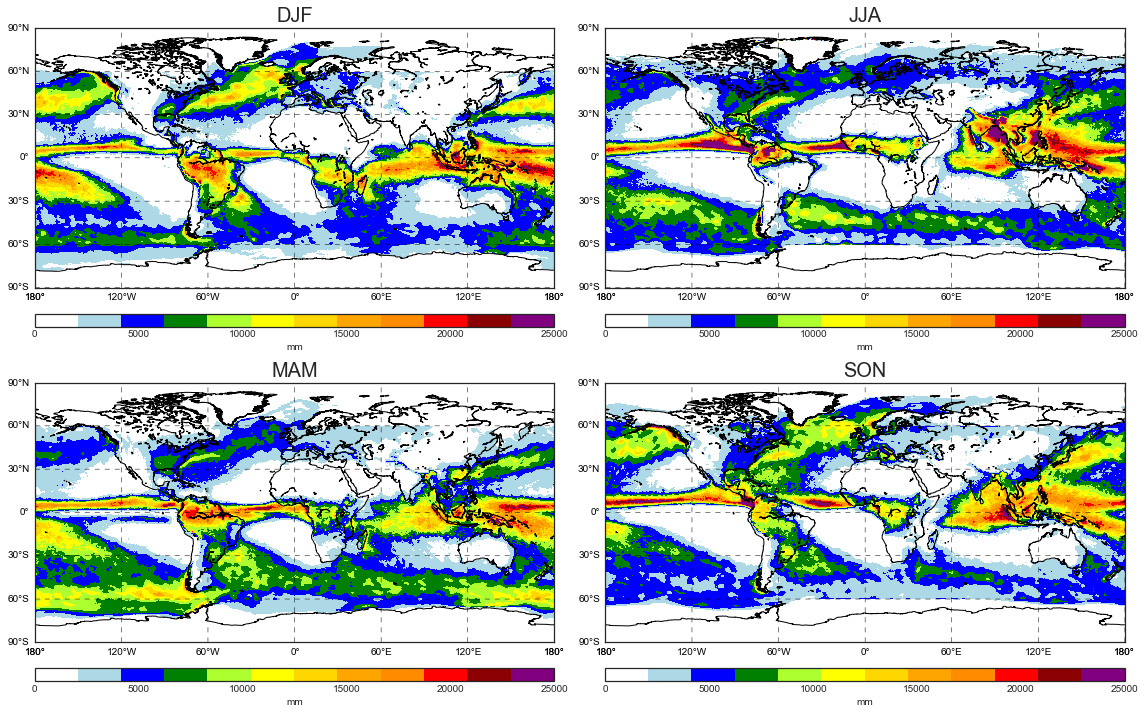

In [94]:
cmap_data= ['white',"lightblue","blue", "green",
                        "greenyellow", "yellow","gold","orange", "darkorange",
                        "red", "darkred", "purple"]
fig= plt.figure(figsize=(16,10))

ax= fig.add_subplot(2,2,1)
ax.set_title('DJF', fontsize=20)
map= visual(np.flip(season['DJF'][:][9,:,:], axis=0), 'mm', True, cmap_data, vmin=0, vmax= 25000)

ax= fig.add_subplot(2,2,2)
ax.set_title('JJA', fontsize=20)
map= visual(np.flip(season['JJA'][:][9,:,:], axis=0), 'mm', True, cmap_data,  vmin=0, vmax= 25000)

ax= fig.add_subplot(2,2,3)
ax.set_title('MAM', fontsize=20)
map= visual(np.flip(season['MAM'][:][9,:,:], axis=0), 'mm', True, cmap_data, vmin=0, vmax= 25000)

ax= fig.add_subplot(2,2,4)
ax.set_title('SON', fontsize=20)
map= visual(np.flip(season['SON'][:][9,:,:], axis=0), 'mm', True, cmap_data, vmin=0, vmax= 25000)
plt.tight_layout()
# fig.savefig('seasonalAmtFinal.png', dpi=144)

### Plot early-final deficit

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/i

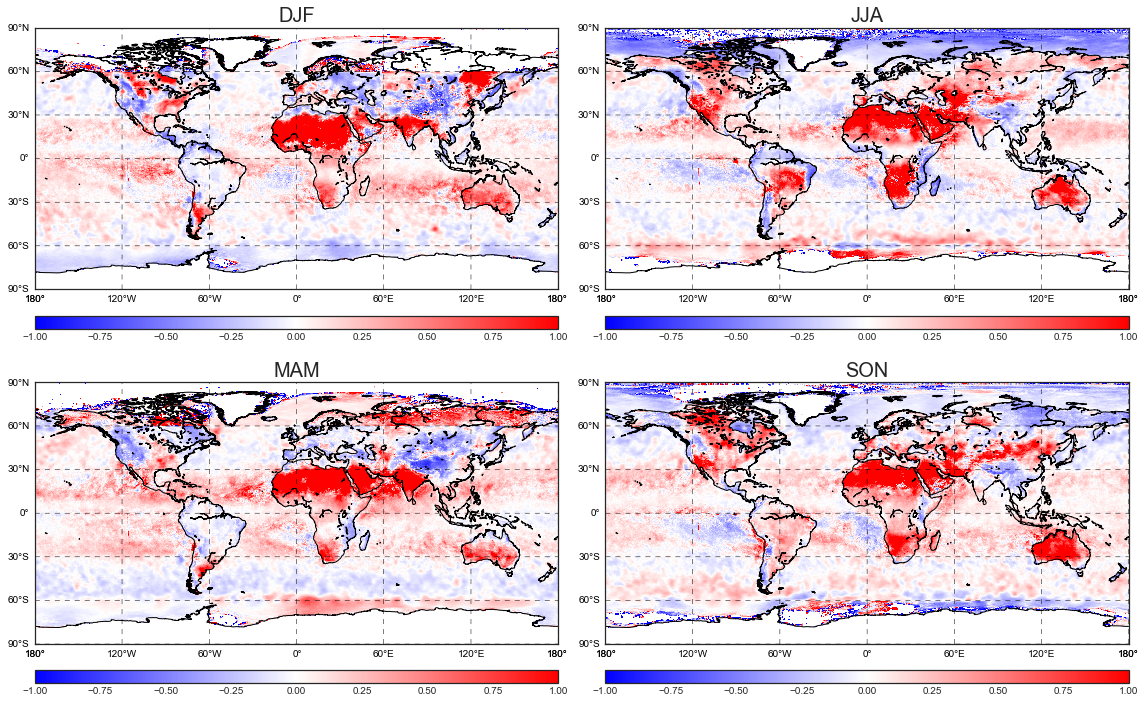

In [79]:
fig= plt.figure(figsize=(16,10))

ax= fig.add_subplot(2,2,1)
ax.set_title('DJF', fontsize=20)
map= visual(np.flip((season['DJF'][:][8,:,:]-season['DJF'][:][9,:,:])/season['DJF'][:][9,:,:], axis=0), '', vmin=-1, vmax=1, cmap='bwr')

ax= fig.add_subplot(2,2,2)
ax.set_title('JJA', fontsize=20)
map= visual(np.flip((season['JJA'][:][8,:,:]-season['JJA'][:][9,:,:])/season['JJA'][:][9,:,:], axis=0), '', vmin=-1, vmax=1, cmap='bwr')

ax= fig.add_subplot(2,2,3)
ax.set_title('MAM', fontsize=20)
map= visual(np.flip((season['MAM'][:][8,:,:]-season['MAM'][:][9,:,:])/season['MAM'][:][9,:,:], axis=0), '', vmin=-1, vmax=1, cmap='bwr')

ax= fig.add_subplot(2,2,4)
ax.set_title('SON', fontsize=20)
map= visual(np.flip((season['SON'][:][8,:,:]-season['SON'][:][9,:,:])/season['SON'][:][9,:,:], axis=0), '', vmin=-1, vmax=1, cmap='bwr')
plt.tight_layout()
# fig.savefig('seasonalAmtBias.png', dpi=144)

In [63]:
def flatten(src):
    src= src.reshape(-1,1)
    src= src[~np.isnan(src)]
    
    return src

### Plot four subplots that illustrate the RMS difference

In [74]:
rmse= {}

for i, k in enumerate(['DJF', 'JJA', 'MAM', 'SON']):
    rainySamples= np.flip(season[k][:][4:7].sum(axis=0),axis=0)
    _rmse= np.flip(season[k][:][2,:,:], axis=0)
    _rmse= (_rmse/rainySamples)**.5
    rmse[k]= _rmse

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


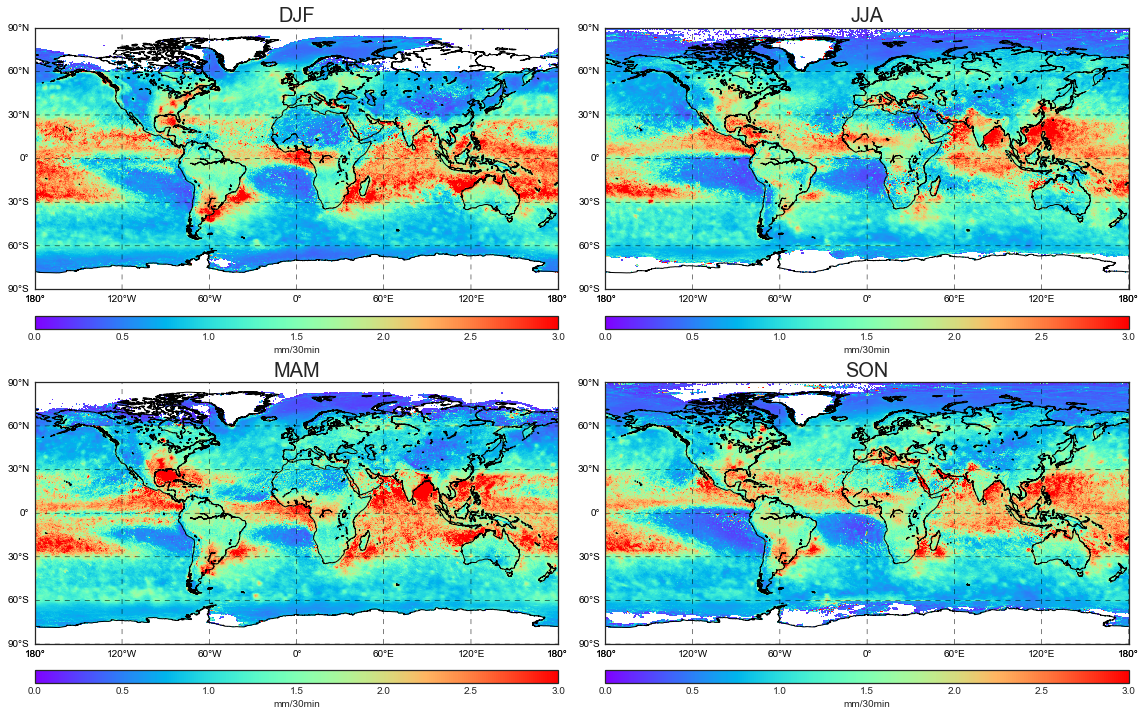

In [78]:
fig= plt.figure(figsize=(16,10))

ax= fig.add_subplot(2,2,1)
ax.set_title('DJF', fontsize=20)
map= visual(rmse['DJF'], 'mm/30min', vmin=0, vmax=3)

ax= fig.add_subplot(2,2,2)
ax.set_title('JJA', fontsize=20)
map= visual(rmse['JJA'], 'mm/30min', vmin=0, vmax=3)

ax= fig.add_subplot(2,2,3)
ax.set_title('MAM', fontsize=20)
map= visual(rmse['MAM'], 'mm/30min', vmin=0, vmax=3)

ax= fig.add_subplot(2,2,4)
ax.set_title('SON', fontsize=20)
map= visual(rmse['SON'], 'mm/30min', vmin=0, vmax=3)
plt.tight_layout()
# fig.savefig('seasonalRMSD.png', dpi=144)

In [5]:
first= np.load('datasets/0.npy')
second= np.load('datasets/30.npy')
np.equal(first[2,:,:], second[2,:,:])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [6]:
def mapToLST(P0, lons, lon0, lon1):

    utc2lst = np.int32(np.round(lons[lon0 : lon1] / 7.5))    # 7.5° / hhr
    P1 = np.zeros(P0.shape, 'f4')

    for lon in range(lon1 - lon0):
        for hhr in range(48):
            P1[(hhr + utc2lst[lon]) % 48, lon, :] = P0[hhr, lon, :]

    return P1

def getDiurnalData(key='rmse'):
    new_arr= np.zeros((48,1800,3600), dtype= np.float32)
    for i, time in enumerate(range(0,1440,30)):
        _temp= np.load('datasets/%d.npy'%time)
        if key=='rmse':
            _rmse= np.divide(_temp[2,:,:], _temp[4:7,:,:].sum(axis=0), where= _temp[4:7,:,:].sum(axis=0)!=0, out = np.full(_temp[2,:,:].shape, np.nan), dtype= np.float32)**0.5
            new_arr[i,:,:]= _rmse
        elif key=='final':
            _final= np.divide(_temp[9,:,:], _temp[4:6,:,:].sum(axis=0), where= _temp[4:6,:,:].sum(axis=0)!=0, out = np.full(_temp[9,:,:].shape, np.nan), dtype= np.float32)
            new_arr[i,:,:]= _final
        elif key=='bias':
            _bias= np.divide(_temp[8,:,:]-_temp[9,:,:], _temp[9,:,:], where= _temp[9,:,:]!=0, out= np.full(_temp[9,:,:].shape, np.nan), dtype= np.float32)
            new_arr[i,:,:]= _bias
            
    return new_arr

In [36]:
diurnalArr= getDiurnalData('rmse')
diurnalArr_max= diurnalArr.copy()
diurnalArr_min= diurnalArr.copy()
diurnalArr_max[np.isnan(diurnalArr_max)]= 0
diurnalArr_min[np.isnan(diurnalArr_min)]= 9999

In [37]:
peakTime_neg= np.nanargmin(diurnalArr_min, axis=0)
peakTime_pos= np.nanargmax(diurnalArr_max, axis=0)

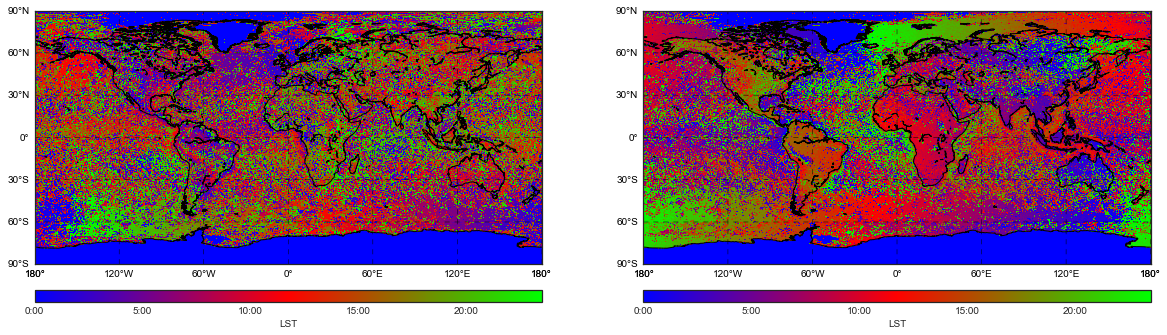

In [38]:
fig= plt.figure(figsize=(20,6))
ax= fig.add_subplot(121)
map= visual(np.flip(peakTime_pos, axis=0), 'LST', False, None, cmap='brg')
ax= fig.add_subplot(122)
map= visual(np.flip(peakTime_neg, axis=0), 'LST', False, None, cmap='brg')


In [39]:
fig.savefig('peak_rmse.png', dpi=144)

In [81]:
mapedDiurnalArr= mapToLST(diurnalArr.transpose(0,2,1), LON, 0, len(LON))

In [83]:
for i in range(48):
    _arr= mapedDiurnalArr[i,:,:].transpose(1,0)
    fig= plt.figure(figsize=(10,6))
    ax= fig.add_subplot()
    map= visual(np.flip(_arr, axis=0), 'mm/30min', False, None, vmin=-1, vmax=1)
    ax.set_title('%d minutes'%(int(i)*30), fontsize=20)
    fig.savefig('gifs_bias/%04d.png'%(int(i)*30), dpi=144)
    plt.close()
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


## Available data

In [9]:
nanNum_E= np.zeros((1800,3600))
nanNum_F= np.zeros((1800,3600))
for s in ['DJF', 'JJA', 'MAM', 'SON']:
    nanNum_E +=season[s][0,:,:]
    nanNum_F += season[s][1,:,:]

In [10]:
totalNum= len(pd.date_range('20000601', '20190630', freq='30T'))

In [11]:
avaiNum_E= totalNum- nanNum_E
avaiNum_F= totalNum- nanNum_F

In [12]:
numP_E= np.divide(avaiNum_E, totalNum)*100.
numP_F= np.divide(avaiNum_F, totalNum)*100.

Text(0.5, 1.0, 'ER')

Text(0.5, 1.0, 'FR')

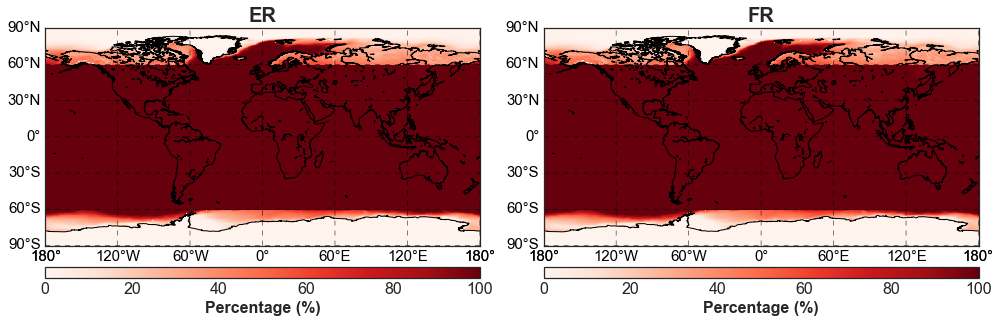

In [11]:
fig= plt.figure(figsize=(14,8))
ax= fig.add_subplot(1,2,1)
ax.set_title('ER', fontsize=20, weight='bold')
map= visual(np.flip(numP_E, axis=0), 'Percentage (%)',False,'',cmap='Reds', vmin=0, vmax=100)

ax= fig.add_subplot(1,2,2)
ax.set_title('FR', fontsize=20, weight='bold')
map= visual(np.flip(numP_F, axis=0), 'Percentage (%)',False,'',cmap='Reds', vmin=0, vmax=100)

In [12]:
fig.savefig('available_data_percent.png', dpi=300)

## Rainy probability

In [8]:
cmap_data= [
#     '#2b83ba',
    '#2b83ba',
    '#81bfab',
    '#c8e9ad',
    '#ffffbe',
    '#fec87f',
    '#f07a49',
    '#d7181e',
    '#ba1089',
    '#bb50c7',
    '#d7d7d7',

]

In [15]:
rainP_E= np.zeros((1800,3600))
rainP_F= np.zeros((1800,3600))
for s in ['DJF', 'JJA', 'MAM', 'SON']:
    rainP_E +=np.nansum(season[s][[4,6],:,:], axis=0)
    rainP_F +=np.nansum(season[s][[4,5],:,:], axis=0)

In [16]:
rainP_E= np.divide(rainP_E, totalNum)*100.
rainP_F= np.divide(rainP_F, totalNum)*100.

Text(0.5, 1.0, 'ER-FR')

Text(0.5, 1.0, 'FR')

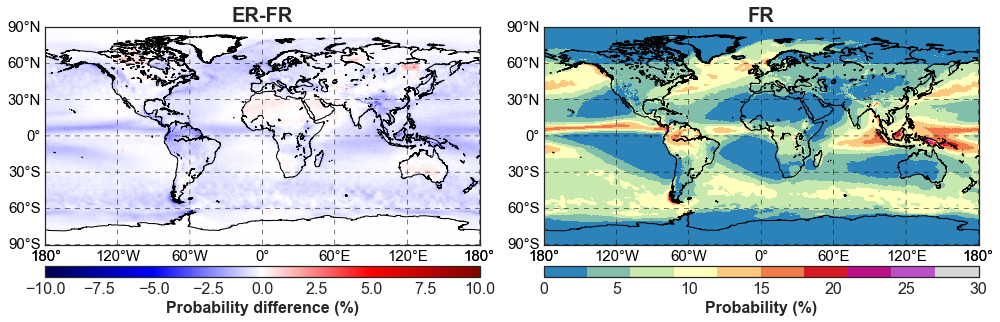

In [27]:
fig= plt.figure(figsize=(14,8))
ax= fig.add_subplot(1,2,1)
ax.set_title('ER-FR', fontsize=20, weight='bold')
map= visual(np.flip(rainP_E-rainP_F, axis=0), 'Probability difference (%)',True, cmap='seismic', vmin=-10, vmax=10)

ax= fig.add_subplot(1,2,2)
ax.set_title('FR', fontsize=20, weight='bold')
map= visual(np.flip(rainP_F, axis=0), 'Probability (%)',True, cmap_data, vmin=0, vmax=30)

In [39]:
(rainP_E-rainP_F<0).sum()/(~np.isnan(rainP_E)).sum()

0.795804012345679

In [36]:
np.nanmin(rainP_E[rainP_E>0])

0.0002989849461079635

In [19]:
np.nanmean(rainP_F)

4.870761735989652

In [18]:
np.nanmean((rainP_E-rainP_F)[rainP_E-rainP_F>0])

0.20365989175897672

In [26]:
x,y =np.meshgrid(LON, LAT)

In [35]:
y.reshape(-1)[np.argmin(rainP_F[rainP_F>0])]

-89.95

In [22]:
np.argmax(rainP_E)

2880960

In [17]:
(np.nanmean(rainP_E)-np.nanmean(rainP_F))/np.nanmean(rainP_F)

-0.08472008043706715

In [95]:
from scipy import stats
stats.pearsonr(rainP_E.reshape(-1), rainP_F.reshape(-1))

(0.9974671739972609, 0.0)

In [29]:
fig.savefig('precipitation_probability(new).png', dpi=300)

In [28]:
samples= np.stack([avaiNum_E, avaiNum_F])

In [97]:
samples.shape

(2, 1800, 3600)

In [29]:
np.save('avai_samples.npy', samples)

# Anual rainfall